These codes are modified based on Abhinav Sagar, Nucleus Segmentation using U-Net, https://towardsdatascience.com/nucleus-segmentation-using-u-net-eceb14a9ced4

In [1]:
#import useful libraries
import os
import sys
import random
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from tensorflow import keras
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
from skimage import io
import tensorflow as tf
import pims

In [2]:
# import a tif as stack
def stackloader(filename, dir_in='',plot=True):
    #""""""
    #load and seperate 4D tif pictures into 20 2D figures and then plot them if needed
    
    #Parameters
    #----------
    #filename: string
    #    The name of the files
    #dir_in: string
    #    Specific directory of the files, defaults to empty
    #plot: boolean
    #    True to plot the figures, False only to load the data rather than plot the figures
    
    #Returns
    #-------
    #There are 4 returns: value of nuclei and nps as well as number of rows and columns: nrows,ncols
    #""""""
    #load data
    if dir_in=='':
        data=pims.TiffStack('./'+filename)# if the tif in the same folder as the code does.
    else:
        data=pims.TiffStack(dir_in+filename)#if the dir is not empty, use the dir to open the tif

    nuclei=np.array(data[1::2])#start from 1 with step 2, i.e.1,3,5,7,9...
    nps=np.array(data[::2])#start from 0 with step size 2, i.e. 0,2,4,6,8...
    z_size,y_size,x_size=np.shape(nuclei)# shape on nps, nuclei, data like a square matrix
    #print(np.shape(data)) #(40,512,521),512 entries in x y axes,with 20 in Z and 2 channel,total 40
    nrows=np.int(np.ceil(np.sqrt(z_size)))
    ncols=np.int(z_size//nrows+1)
    if plot==True:
        fig,axes=plt.subplots(nrows,ncols,figsize=(3*ncols,3*nrows))
        for n in range(z_size):
            i=n//ncols
            j=n%ncols
            axes[i,j].imshow(nuclei[n],interpolation='nearest',cmap='gray')#total 20 necleis,total 20 pictures
        for ax in axes.ravel():# returns contiguous flattened array(ravel() return an array to 1D) 
            if not(len(ax.images)):
                fig.delaxes(ax)# remove the Axes ax from its figure.
        fig.tight_layout()
        plt.show()
        plt.close()# reduce memory after function.
        
    return nuclei, nps, nrows,ncols

#Change tif into 2d picture and plot it
def plotpic(filename, dir_in='',plot=True):
    #""""""
    #transfor 4D tif pictures into 2D figures and then plot the first 2d pictures
    
    #Parameters
    #----------
    #filename: string
    #    The name of the files
    #dir_in: string
    #    Specific directory of the files, defaults to empty
    #plot: boolean
    #    True to plot the figures
    #""""""
    
    if dir_in=='':
        data='./'+filename# if the tif in the same folder as the code does.
    else:
        data=dir_in+filename# if dir_in not empty, use dir to open the picture
    IM= io.imread(data)[0]#read 1th 2d-picture
    IM_MAX= np.max(IM, axis=0)
    IM_MAX= resize(IM_MAX, (512,512), mode='constant', preserve_range=True)
    if plot==True:
        plt.imshow(IM_MAX,cmap='gray')
        plt.axis('off')
        
        
#In folders, change all tifs into 2d pictures and save them.
def filefolder(dirname='',plot=True):
    #""""""
    #load, plot and save 4D tif pictures into 2D figures in given folders 
    
    #Parameters
    #----------
    #dirname: string
    #    General directory of the file, defaults to empty   
    #plot: boolean
    #    True to plot and save the figures in a given folder
    #""""""
    
    if dirname!='':# if dirname is not empty, use given dir
            dirname=dirname
    else:# if dirname is empty
            dirname='./'+dirname
    dirs=os.listdir(dirname)# read all sub-folders' names in dirname folder
    n_files=len(dirs)
    for i in range(0,n_files):
        dataname=dirname+dirs[i]+'/'
        data=dataname+'tifs/'# for tifs subsub-folder in sub-folders,
        dir_1=os.listdir(data)# read all tifs pictures' names
        k=len(dir_1)
        for j in range(0,k):
            if dir_1[j]!='.DS_Store':#check whether it is tifs folders
                name=data+dir_1[j]
                IM= io.imread(name)[0]
                IM_MAX= np.max(IM, axis=0)
                IM_MAX= resize(IM_MAX, (512,512), mode='constant', preserve_range=True)
                if plot==True:
                    plt.imshow(IM_MAX,cmap='gray')
                    plt.axis('off')
                    figure_save_path ='test_set/'+dirs[i]+'/images/'# dir to save pictures
                    figure_save_path2 ='train_set/'+dirs[i]+'/images/'# dir to save pictures
                    if not os.path.exists(figure_save_path):# if directory not exist, create it
                        os.makedirs(figure_save_path)   
                    plt.savefig(os.path.join(figure_save_path , '{}'.format(dir_1[j])),bbox_inches='tight', pad_inches = -0.1)
                    if not os.path.exists(figure_save_path2):# if directory not exist, create it
                        os.makedirs(figure_save_path2)   
                    plt.savefig(os.path.join(figure_save_path2 , '{}'.format(dir_1[j])),bbox_inches='tight', pad_inches = -0.1)
                    plt.close()#close the figures, so the plot will not display

C:\Users\ZKR\AppData\Local\Temp\ipykernel_10256\1874345460.py:29: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  nrows=np.int(np.ceil(np.sqrt(z_size)))
C:\Users\ZKR\AppData\Local\Temp\ipykernel_10256\1874345460.py:30: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release not

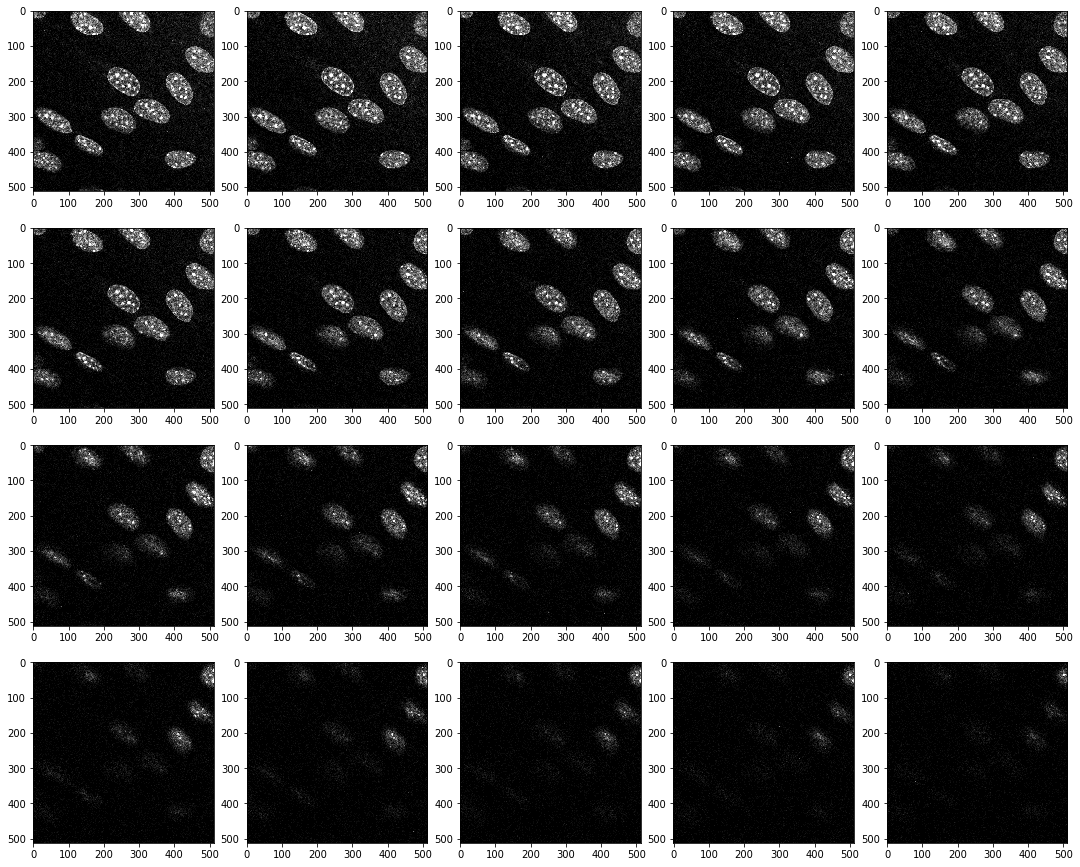

In [3]:
nuclei, nps, nrows,ncols=stackloader('1.2%_1Hour_A-Tubulin.lif - Series001.tif', dir_in='tifs - unanalysed/1.2%_1Hour_A-Tubulin/tifs/',plot=True)

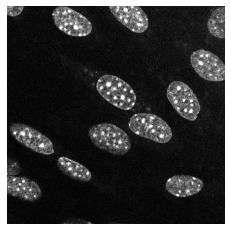

In [4]:
plotpic('1.2%_1Hour_A-Tubulin.lif - Series001.tif', dir_in='tifs - unanalysed/1.2%_1Hour_A-Tubulin/tifs/',plot=True)

In [5]:
filefolder(dirname='tifs - unanalysed/',plot=True)

In [6]:
BATCH_SIZE = 10 # the higher the better
IMG_WIDTH = 128 # for faster computing on kaggle
IMG_HEIGHT = 128 # for faster computing on kaggle
IMG_CHANNELS = 3 
TRAIN_PATH = './stage1_train/'
TEST_PATH='./test_set/'# our project
warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42

In [7]:
#load all the file name into training and testing directory
train_ids = next(os.walk(TRAIN_PATH))[1]# why [1]?
test_ids = next(os.walk(TEST_PATH))[1]
np.random.seed(10)#the 10th seed


In [8]:
# build X and Y train set
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

print('Getting and resizing train images and masks ... ')
sys.stdout.flush()#output on the same line with time interval
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):#why _
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    #make tif from 256*256 to 128*128 to increase computational speed
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:#what is [2]
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)
    Y_train[n] = mask# what do this mask fun do?

Getting and resizing train images and masks ... 


C:\Users\ZKR\AppData\Local\Temp\ipykernel_10256\2171445504.py:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
  0%|                                                                                          | 0/670 [00:00<?, ?it/s]C:\Users\ZKR\AppData\Local\Temp\ipykernel_10256\2171445504.py:13: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidanc

In [9]:
#build our test set

X_test = np.zeros((6*len(test_ids)-3, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
#just to ensure that len of X_test is equal to len of sizes_test
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
n=0
for id_ in tqdm(test_ids, total=len(test_ids)):
    path = TEST_PATH + id_+'/images/'
    dir_3=os.listdir(path)
    k=len(dir_3)
    for i in range(0,k): 
        img = imread(path +dir_3[i])[:,:,:IMG_CHANNELS] # look for all pictures with name Series001
        sizes_test.append([img.shape[0], img.shape[1]])# append sizes of figures i.e. 256*256 pixel: [256,256]
        img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
        X_test[n]=img
        n+=1
print('Done!')

Getting and resizing test images ... 


100%|████████████████████████████████████████████████████████████████████████████████| 127/127 [00:30<00:00,  4.15it/s]

Done!


In [10]:
from keras.preprocessing import image
# build data augmentation to avoid the overfitting of a model and also to increase the ability of our model to generalize.

# Creating the training Image and Mask generator (zoom in range[0.8,1.2])
image_datagen = image.ImageDataGenerator(shear_range=0.5, rotation_range=50, zoom_range=0.2, width_shift_range=0.2, height_shift_range=0.2, fill_mode='reflect')
mask_datagen = image.ImageDataGenerator(shear_range=0.5, rotation_range=50, zoom_range=0.2, width_shift_range=0.2, height_shift_range=0.2, fill_mode='reflect')

# Keep the same seed for image and mask generators so they fit together
image_datagen.fit(X_train[:int(X_train.shape[0]*0.9)], augment=True, seed=seed)#90% train data to fit
mask_datagen.fit(Y_train[:int(Y_train.shape[0]*0.9)], augment=True, seed=seed)

# flow method generate batch of augmented data
x=image_datagen.flow(X_train[:int(X_train.shape[0]*0.9)],batch_size=BATCH_SIZE,shuffle=True, seed=seed)
y=mask_datagen.flow(Y_train[:int(Y_train.shape[0]*0.9)],batch_size=BATCH_SIZE,shuffle=True, seed=seed)

# Creating the validation Image and Mask generator
image_datagen_val = image.ImageDataGenerator()
mask_datagen_val = image.ImageDataGenerator()

image_datagen_val.fit(X_train[int(X_train.shape[0]*0.9):], augment=True, seed=seed)#other 10% apart from 90%
mask_datagen_val.fit(Y_train[int(Y_train.shape[0]*0.9):], augment=True, seed=seed)

x_val=image_datagen_val.flow(X_train[int(X_train.shape[0]*0.9):],batch_size=BATCH_SIZE,shuffle=True, seed=seed)
y_val=mask_datagen_val.flow(Y_train[int(Y_train.shape[0]*0.9):],batch_size=BATCH_SIZE,shuffle=True, seed=seed)

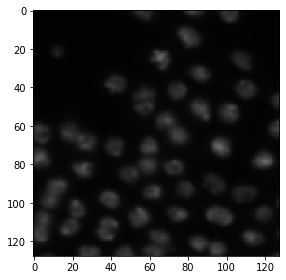

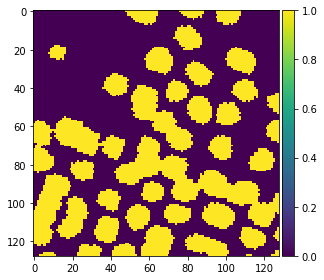

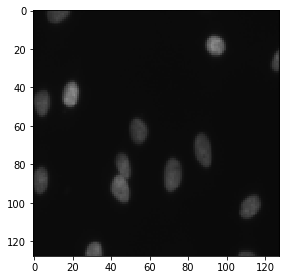

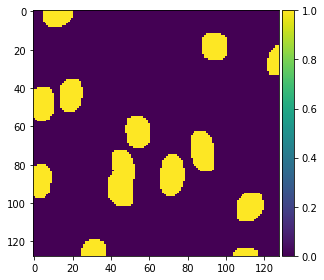

In [11]:
from matplotlib import pyplot as plt
%matplotlib inline
#show the plots in the output，otherwise not

imshow(x.next()[0].astype(np.uint8))
plt.show()
imshow(np.squeeze(y.next()[0].astype(np.uint8)))
plt.show()
imshow(x_val.next()[0].astype(np.uint8))
plt.show()
imshow(np.squeeze(y_val.next()[0].astype(np.uint8)))
plt.show()

In [12]:
train_generator = zip(x, y)
val_generator = zip(x_val, y_val)

In [13]:
#from keras import backend as K
#calculate mean IOU
#IOU = true_positive / (true_positive + false_positive + false_negative). 
#iou = true_positives / (sum_row + sum_col - true_positives))
#def mean_iou(y_true, y_pred):
    #prec = []
    #for t in np.arange(0.5, 1.0, 0.05):
        #return a Tensor with with type int32.
        #y_pred_=tf.cast(y_pred > t, tf.int32)
        #score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2) ???
        #score = tf.keras.metrics.MeanIoU(num_classes=2)
        #up_opt=score(y_true, y_pred)
        #up_opt=score.update_state(y_true, y_pred, sample_weight=None)
        #K.get_session().run(tf.local_variables_initializer()) #return an Op that initializes all local variables in the graph
        #with tf.control_dependencies([up_opt]):
            #score = tf.identity(score)
            #explicitly transport tensor between devices (i.e.from GPU to a CPU). The op adds send/recv nodes to the graph, 
            #which make a copy when the devices of the input and the output are different.
        #prec.append(score)
   #return K.mean(K.stack(prec), axis=0)
    #return score.result().numpy()

In [14]:
#build U-Net model

inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)#axis?
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])#tf.keras.metrics.MeanIoU(num_classes=2)
model.summary()



Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 128, 128, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 448         lambda[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 128, 128, 16) 0           conv2d[0][0]                     
______________________________________________________________________________________________

In [15]:
# fit the model
#Stop training when a monitored metric has stopped improving.
earlystopper = EarlyStopping(patience=50, verbose=1)
# save a model or weights (in a checkpoint file) at some interval, 
#so the model or weights can be loaded later to continue the training from the state saved.
checkpointer = ModelCheckpoint('model.h5', verbose=1, save_best_only=True)
#default batch size is 32. We use fit_generator(), since there are data argumentation
results = model.fit_generator(train_generator, validation_data=val_generator, validation_steps=10, steps_per_epoch=150,
                              epochs=10, callbacks=[earlystopper, checkpointer])


Epoch 1/10


C:\Users\ZKR\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


150/150 [==============================] - 67s 429ms/step - loss: 0.2635 - accuracy: 0.8450 - val_loss: 0.2066 - val_accuracy: 0.9227

Epoch 00001: val_loss improved from inf to 0.20658, saving model to model.h5
Epoch 2/10
150/150 [==============================] - 65s 431ms/step - loss: 0.1543 - accuracy: 0.8958 - val_loss: 0.1230 - val_accuracy: 0.9536

Epoch 00002: val_loss improved from 0.20658 to 0.12301, saving model to model.h5
Epoch 3/10
150/150 [==============================] - 66s 440ms/step - loss: 0.1355 - accuracy: 0.9021 - val_loss: 0.0898 - val_accuracy: 0.9649

Epoch 00003: val_loss improved from 0.12301 to 0.08976, saving model to model.h5
Epoch 4/10
150/150 [==============================] - 72s 480ms/step - loss: 0.1309 - accuracy: 0.9037 - val_loss: 0.0882 - val_accuracy: 0.9658

Epoch 00004: val_loss improved from 0.08976 to 0.08825, saving model to model.h5
Epoch 5/10
150/150 [==============================] - 71s 474ms/step - loss: 0.1309 - accuracy: 0.9032 - va

In [16]:
#model history
results.history

{'loss': [0.263450026512146,
  0.1543382853269577,
  0.13546226918697357,
  0.1308618038892746,
  0.13094477355480194,
  0.12501327693462372,
  0.11664550006389618,
  0.11575017869472504,
  0.11443614214658737,
  0.11153192818164825],
 'accuracy': [0.8450188636779785,
  0.8957738876342773,
  0.9021420478820801,
  0.9036932587623596,
  0.903236448764801,
  0.9055179357528687,
  0.9071692824363708,
  0.9077979922294617,
  0.9083316922187805,
  0.90948486328125],
 'val_loss': [0.20657594501972198,
  0.12301215529441833,
  0.08975853025913239,
  0.08824946731328964,
  0.10449446737766266,
  0.08623433858156204,
  0.07854484021663666,
  0.07930506020784378,
  0.08182220906019211,
  0.08627237379550934],
 'val_accuracy': [0.9227427244186401,
  0.953626275062561,
  0.9648966193199158,
  0.9658456444740295,
  0.9605479836463928,
  0.9657875895500183,
  0.9685532450675964,
  0.967912495136261,
  0.9679039716720581,
  0.9654717445373535]}

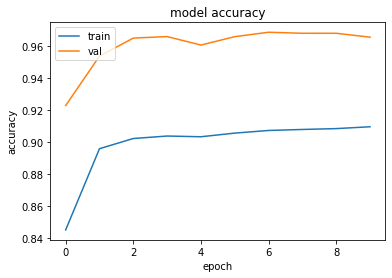

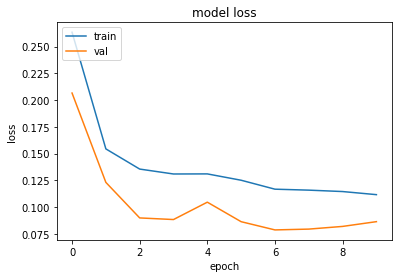

In [17]:
# summarize history and plot the relevant data
fig = plt.figure()

# summarize history for mean_iou and loss
plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
#fig.savefig('my_figure_1.png')

plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
#fig.savefig('my_figure_2.png')



In [18]:
#load the model and use it to make predicted results
model = load_model('model.h5', custom_objects={'accuracy': 'accuracy'})
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8) #why choose 0.5?
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

# Create list of upsampled test masks
preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True))

24/24 [==============================] - 9s 360ms/step


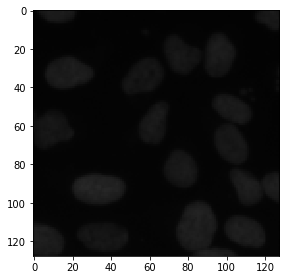

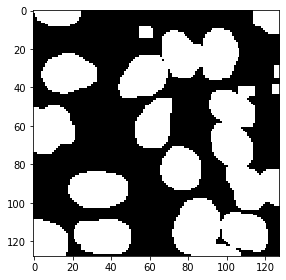

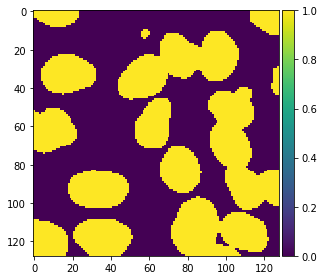

In [19]:
# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

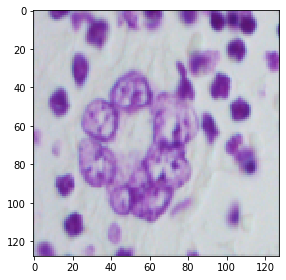

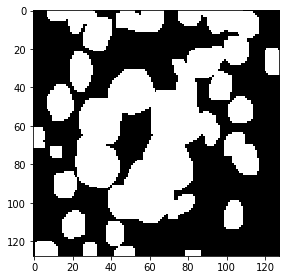

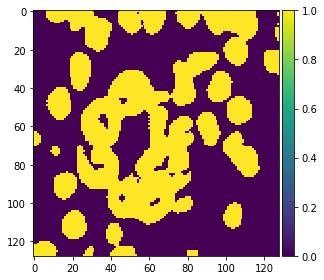

In [20]:
# Perform a sanity check on some random validation samples
ix = random.randint(0, len(preds_val_t))
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()

In [21]:
len(preds_test)

759